# Loading Data

In [13]:
# https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences
# https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip

In [14]:
import os

data_dir = f'{os.getcwd()}/data'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [15]:
# pip install requests
import requests

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip'

response = requests.get(url)

In [16]:
response.content[:10]

b'PK\x03\x04\n\x00\x00\x00\x00\x00'

In [17]:
import zipfile

from io import BytesIO


with zipfile.ZipFile(file=BytesIO(response.content), mode='r') as compressed_file:
    compressed_file.extractall(data_dir)

In [18]:
df_list = []

for csv_file in ['imdb_labelled.txt', 'yelp_labelled.txt',  'amazon_cells_labelled.txt']:

    csv_file_with_path = f'{data_dir}/sentiment labelled sentences/{csv_file}'
    temp_df = pd.read_csv(
        csv_file_with_path, 
        sep="\t", header=0, 
        names=['text', 'sentiment']
    ) 
    df_list.append(temp_df)
    
df = pd.concat(df_list)

In [19]:
df.columns

Index(['text', 'sentiment'], dtype='object')

In [20]:
df.shape

(2745, 2)

/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


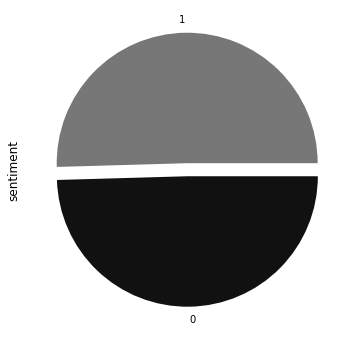

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

explode = [0.05, 0.05]
colors = ['#777777', '#111111']
df['sentiment'].value_counts().plot(
    kind='pie', colors=colors, explode=explode, ax=ax
)

fig.show()

In [10]:
df['sentiment'].value_counts() / df['sentiment'].shape[0]

1    0.504554
0    0.495446
Name: sentiment, dtype: float64

In [11]:
pd.options.display.max_colwidth = 90

In [12]:
df[['text', 'sentiment']].sample(5, random_state=42)

,text,sentiment
471,This is a stunning movie.,1
278,I had the mac salad and it was pretty bland so I will not be getting that again.,0
20,"The food, amazing.",1
150,"Audio Quality is poor, very poor.",0
430,His acting alongside Olivia De Havilland was brilliant and the ending was fantastic!,1


In [207]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.4, random_state=42)

In [208]:
df_train.shape[0], df_test.shape[0]

(1647, 1098)

In [209]:
y_train = df_train['sentiment']
y_test = df_test['sentiment']

In [210]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1,3), min_df=3, strip_accents='ascii')

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [211]:
pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

,token
id,
0,10
1,12
2,20
3,20 minutes
4,30
...,...
1834,your money
1835,your time
1836,yourself


In [212]:
x_train

<1647x1839 sparse matrix of type '<class 'numpy.int64'>'
	with 19648 stored elements in Compressed Sparse Row format>

In [213]:
x_test

<1098x1839 sparse matrix of type '<class 'numpy.int64'>'
	with 12322 stored elements in Compressed Sparse Row format>

In [214]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")

dummy_clf.fit(x_train, y_train)

y_dummy_test_pred = dummy_clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_dummy_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index=[0,1] 
).round(2)

,Precision,Recall,F,Support
0,0.51,0.47,0.49,565
1,0.48,0.51,0.50,533


In [222]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=True)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index=[0,1] 
).round(2)

,Precision,Recall,F,Support
0,0.81,0.78,0.79,565
1,0.77,0.80,0.79,533


In [223]:
pd.Series(p).round(2)

0    0.81
1    0.77
dtype: float64

In [229]:
pd.Series(p).round(4).mean()

0.7897

In [230]:
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 78.97% & Recall=78.99%


In [231]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7896174863387978

In [232]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=False)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index=[0,1] 
)

,Precision,Recall,F,Support
0,0.798214,0.791150,0.794667,565
1,0.780669,0.787992,0.784314,533


In [154]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7896174863387978

Micro FScore = 0.7978142076502732 @ ngram_range = (1, 1)
Micro FScore = 0.6520947176684881 @ ngram_range = (2, 2)
Micro FScore = 0.5373406193078324 @ ngram_range = (3, 3)
Micro FScore = 0.5136612021857924 @ ngram_range = (4, 4)
Micro FScore = 0.5127504553734062 @ ngram_range = (5, 5)


/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


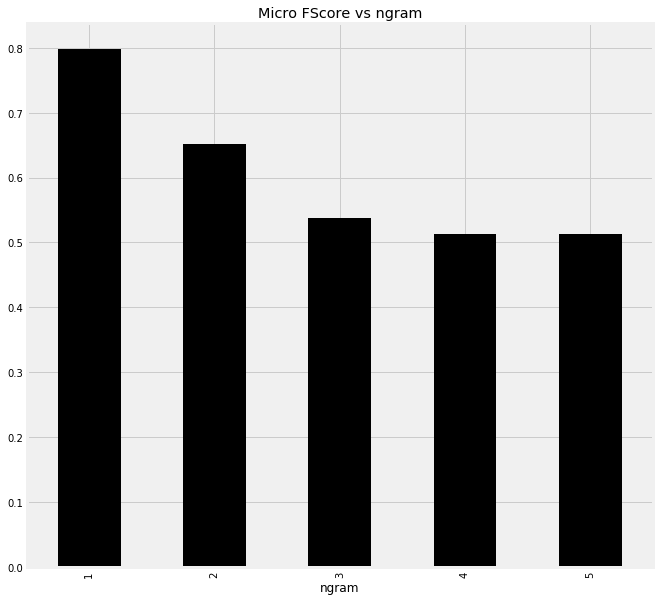

In [155]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

micro_fscores = []

for ngram_range in [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]:

    pipeline = make_pipeline(
        CountVectorizer(ngram_range=ngram_range, min_df=3, max_df=0.2, strip_accents='ascii'),
        MultinomialNB(fit_prior=False)
    )

    pipeline.fit(df_train['text'], y_train)
    y_test_pred =  pipeline.predict(df_test['text'])

    p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

    micro_fscore = precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

    print(f'Micro FScore = {micro_fscore} @ ngram_range = {ngram_range}')
    
    micro_fscores.append([ngram_range[-1], micro_fscore])
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

pd.DataFrame(
    micro_fscores,
    columns=['ngram', 'Micro FScore']
).set_index('ngram')['Micro FScore'].plot(
    title='Micro FScore vs ngram',
    color='k',
    kind='bar',
    ax=ax,
)

fig.show()

/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


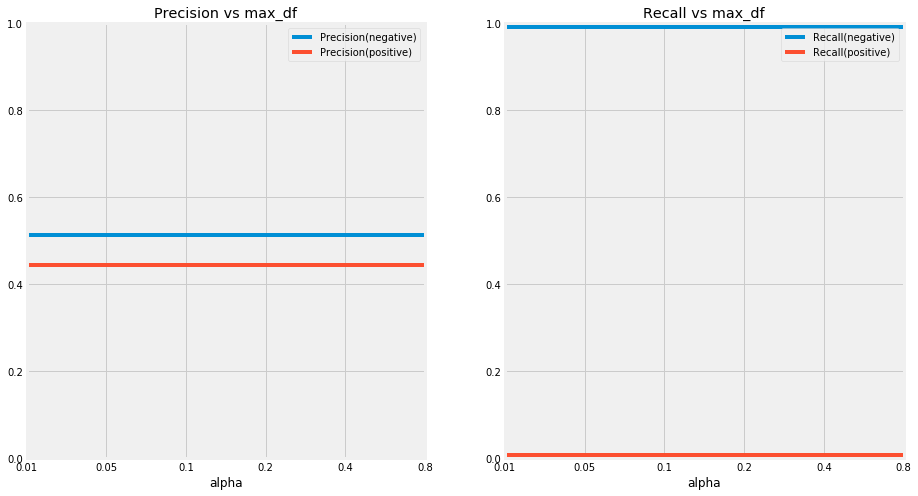

In [156]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

precision_scores = []
recall_scores = []

for max_df in [.01, .05, .1, .2, .4, .8]:

    pipeline = make_pipeline(
        CountVectorizer(ngram_range=(4,4), min_df=3, max_df=max_df, strip_accents='ascii'),
        MultinomialNB(fit_prior=False, alpha=1)
    )

    pipeline.fit(df_train['text'], y_train)
    y_test_pred =  pipeline.predict(df_test['text'])

    p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)
    
    precision_score = [f'{max_df}']
    precision_score.extend(p)
    
    recall_score = [f'{max_df}']
    recall_score.extend(r)
    
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

pd.DataFrame(
    precision_scores,
    columns=['alpha', 'Precision(negative)',  'Precision(positive)']
).set_index('alpha').plot(
    title='Precision vs max_df',
    # color='k',
    kind='line',
    ylim=(0,1),
    ax=axs[0],
)

pd.DataFrame(
    recall_scores,
    columns=['alpha', 'Recall(negative)', 'Recall(positive)']
).set_index('alpha').plot(
    title='Recall vs max_df',
    # color='k',
    kind='line',
    ylim=(0,1),
    ax=axs[1],
)

fig.show()

# GridSearch + Pipeline

In [234]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline(steps=[('CountVectorizer', CountVectorizer()), ('MultinomialNB', MultinomialNB())])

In [235]:
param_grid = {
    'CountVectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'MultinomialNB__alpha': [0.1, 1],
    'MultinomialNB__fit_prior': [True, False],
}

In [236]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe, param_grid, scoring='precision_macro', n_jobs=-1)
search.fit(df_train['text'], y_train)
print(search.best_params_)

{'CountVectorizer__ngram_range': (1, 3), 'MultinomialNB__alpha': 1, 'MultinomialNB__fit_prior': False}


In [160]:
y_test_pred = search.predict(df_test['text'])

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 80.47% & Recall=80.48%


In [237]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe, param_grid, scoring='recall_macro', n_jobs=-1)
search.fit(df_train['text'], y_train)
print(search.best_params_)

{'CountVectorizer__ngram_range': (1, 3), 'MultinomialNB__alpha': 1, 'MultinomialNB__fit_prior': False}


In [238]:
y_test_pred = search.predict(df_test['text'])

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 80.47% & Recall=80.48%


In [163]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1,3), min_df=3, max_df=0.2, binary=True, strip_accents='ascii')

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [164]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(fit_prior=False)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index=[0,1] 
)

,Precision,Recall,F,Support
0,0.811252,0.791150,0.801075,565
1,0.784278,0.804878,0.794444,533


In [165]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7978142076502732

In [166]:
df_vocab = pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

df_vocab['positive_coef'] = clf.coef_[0]

In [167]:
df_vocab.sort_values('positive_coef', ascending=False).head(20)

,token,positive_coef
id,,
1000,of,-1.801171
1652,was,-1.937747
692,in,-2.124958
589,great,-2.124958
577,good,-2.196054
1758,with,-2.272594
515,for,-2.343212
1621,very,-2.355482
1359,that,-2.406126


In [168]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index=[0,1] 
)


,Precision,Recall,F,Support
0,0.785467,0.803540,0.794401,565
1,0.786538,0.767355,0.776828,533


In [169]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7859744990892532

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [171]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=False, alpha=0.001)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index=[0,1] 
)

,Precision,Recall,F,Support
0,0.780797,0.762832,0.77171,565
1,0.754579,0.772983,0.76367,533


In [172]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.76775956284153

In [173]:
df_vocab = pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

df_vocab['positive_coef'] = clf.coef_[0]

In [174]:
df_vocab.sort_values('positive_coef', ascending=False).head(20)

,token,positive_coef
id,,
24844,the,-5.299478
1173,and,-5.396813
10733,great,-5.502234
13053,is,-5.606420
13655,it,-5.731052
26803,this,-5.763281
10478,good,-5.813763
27429,to,-6.003960
29459,was,-6.030217


# SpaCy Word Embedding

In [175]:
# pip install spacy
# python -m spacy download en_core_web_lg

In [176]:
import spacy

nlp = spacy.load('en_core_web_md')

In [177]:
# pip install tqdm
from tqdm import tqdm
tqdm.pandas()

In [178]:
import spacy

class WordEmbeddingVectorizer:
    
    def __init__(self, language_model='en_core_web_md'):
        self.nlp = spacy.load(language_model)
    
    def fit(self):
        pass
    
    def transform(self, x, y=None):
        return pd.Series(x).progress_apply(
            lambda doc: self.nlp(doc).vector.tolist()
        ).values.tolist()
    
    def fit_transform(self, x, y=None):
        return self.transform(x)
    

vec = WordEmbeddingVectorizer()
x_train_w2v = vec.transform(df_train['text'])
x_test_w2v = vec.transform(df_test['text'])

100%|██████████| 1098/1098 [00:10<00:00, 102.28it/s]


In [179]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
# clf = SGDClassifier(loss='log', max_iter=10000, class_weight='balanced')
clf = LogisticRegression(max_iter=10000, class_weight=None)

x_train_scaled = scaler.fit_transform(x_train_w2v)
x_test_scaled = scaler.transform(x_test_w2v)

clf.fit(x_train_scaled, y_train)
y_test_pred = clf.predict(x_test_scaled)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index=[0,1] 
)


,Precision,Recall,F,Support
0,0.844203,0.824779,0.834378,565
1,0.818681,0.838649,0.828545,533


In [180]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.831511839708561